Notebook zawiera kod i analizę danych zawierający krok:
- integracji danych 
- adnotacji populacji komórkowych 
- GSEA 

In [ ]:
#load libraries
library(Seurat)
library(SeuratWrappers)
library(patchwork)  
library(ggplot2)
library(harmony)
library(reticulate)
library(batchelor)
library(mclust)
library(reshape2)
library(Azimuth)
library(SeuratData)
library(patchwork)
library(clusterProfiler)
library(enrichplot)

In [3]:
options(repr.plot.width = 12, repr.plot.height = 6)

In [3]:
# Load all samples for merging and integration
sample1 <- readRDS("C:/Users/48721/Desktop/PRACA MAGISTERSKA/KOD/3.PREPROCESSING/SAMPLE_OUT/sample1_neg.rds")
sample2 <- readRDS("C:/Users/48721/Desktop/PRACA MAGISTERSKA/KOD/3.PREPROCESSING/SAMPLE_OUT/sample2.rds")
sample3 <- readRDS("C:/Users/48721/Desktop/PRACA MAGISTERSKA/KOD/3.PREPROCESSING/SAMPLE_OUT/sample3.rds")
sample4 <- readRDS("C:/Users/48721/Desktop/PRACA MAGISTERSKA/KOD/3.PREPROCESSING/SAMPLE_OUT/sample4_neg.rds")
sample95 <- readRDS("C:/Users/48721/Desktop/PRACA MAGISTERSKA/KOD/3.PREPROCESSING/SAMPLE_OUT/sample95.rds")
sample99 <- readRDS("C:/Users/48721/Desktop/PRACA MAGISTERSKA/KOD/3.PREPROCESSING/SAMPLE_OUT/sample99_neg.rds")

In [6]:
#Helper function for calculating statistics
print_seurat_stats <- function(seurat_object) {
  if (is.null(seurat_object) || length(seurat_object) == 0) {
    cat("The Seurat object is empty or NULL.\n")
    return(NULL)
  }

  remaining_cells <- ncol(seurat_object)
  remaining_genes <- nrow(seurat_object)
  cat("Number of cells:", remaining_cells, "\n")
  cat("Number of genes:", remaining_genes, "\n")
}

In [7]:
seurat_objects <- list(sample1, sample2, sample3, sample4, sample95, sample99)

names(seurat_objects) <- c("sample1", "sample2", "sample3", "sample4", "sample95", "sample99")

for (obj_name in names(seurat_objects)) {
  seurat_object <- seurat_objects[[obj_name]]
  cat("\nStatistics for", obj_name, ":\n")
  print_seurat_stats(seurat_object)
}


Statistics for sample1 :
Number of cells: 4906 
Number of genes: 36601 

Statistics for sample2 :
Number of cells: 725 
Number of genes: 36601 

Statistics for sample3 :
Number of cells: 687 
Number of genes: 36601 

Statistics for sample4 :
Number of cells: 2877 
Number of genes: 36601 

Statistics for sample95 :
Number of cells: 9912 
Number of genes: 36601 

Statistics for sample99 :
Number of cells: 2858 
Number of genes: 36601 


## KROK 1 
Połączenie wszystkich próbek:
- https://satijalab.org/seurat/archive/v4.3/merge
- By default, merge() will combine the Seurat objects based on the raw count matrices, erasing any previously normalized and scaled data matrices
-  If you want to merge the normalized data matrices as well as the raw count matrices, simply pass merge.data = TRUE. This should be done if the same normalization approach was applied to all objects

In [9]:
# we have already normalized dataset
merged <- merge(sample1, y = c(sample2, sample3, sample4,  sample95,sample99), add.cell.ids = c("1", "2", "3", "4","95",  "99"), merge.data = TRUE)

In [ ]:
# double check if it is already normalized - will be float counts observed
LayerData(merged)[10:20, 1:15]

Warning message in LayerData.Assay5(object = object[[assay]], layer = layer, ...):
"multiple layers are identified by data.1 data.2 data.3 data.4 data.5 data.6
 only the first layer is used"
  [[ suppressing 15 column names '1_AAACCCAAGACGACTG-1', '1_AAACCCAAGTACTGGG-1', '1_AAACCCACACACCAGC-1' ... ]]



11 x 15 sparse Matrix of class "dgCMatrix"
                                               
AL732372.1 . . . .        . . . . . . . . . . .
OR4F29     . . . .        . . . . . . . . . . .
AC114498.1 . . . .        . . . . . . . . . . .
OR4F16     . . . .        . . . . . . . . . . .
AL669831.2 . . . .        . . . . . . . . . . .
LINC01409  . . . .        . . . . . . . . . . .
FAM87B     . . . .        . . . . . . . . . . .
LINC01128  . . . 1.902295 . . . . . . . . . . .
LINC00115  . . . .        . . . . . . . . . . .
FAM41C     . . . .        . . . . . . . . . . .
AL645608.6 . . . .        . . . . . . . . . . .

In [10]:
merged$sample <- sapply(strsplit(colnames(merged), "_"), `[`, 1)
table(merged$sample)


   1    2    3    4   95   99 
4906  725  687 2877 9912 2858 

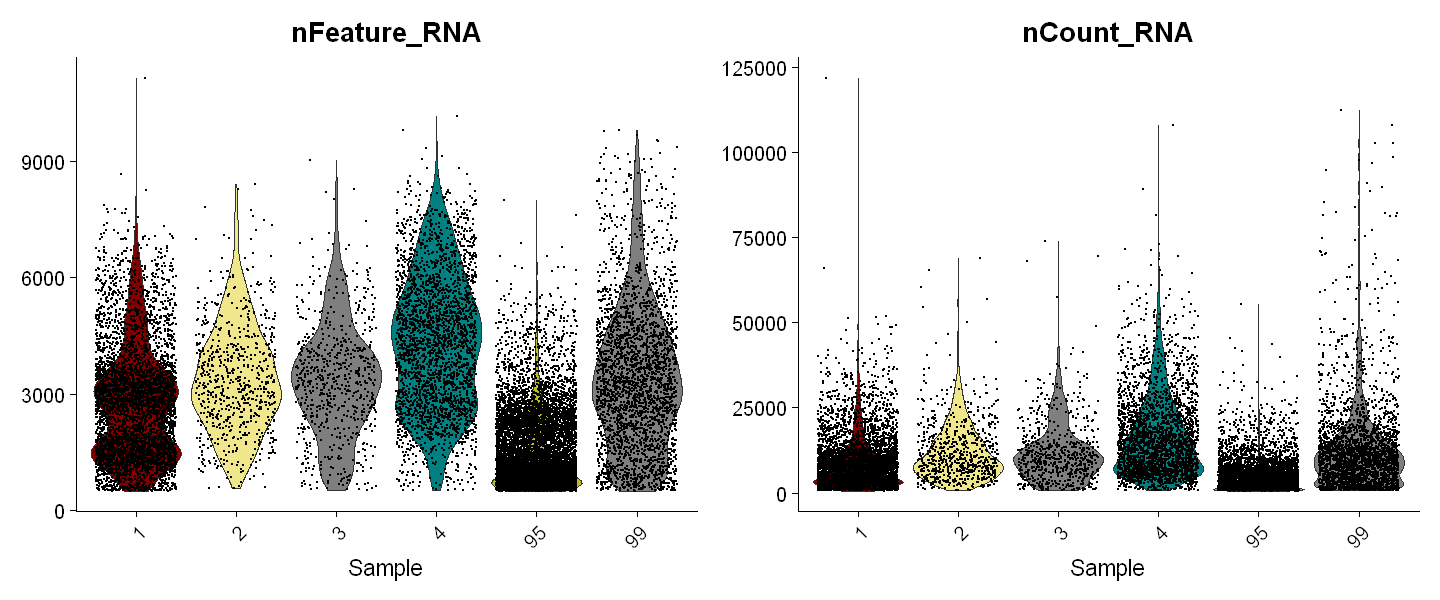

In [ ]:

options(repr.plot.width = 12, repr.plot.height = 5)
p1 <- VlnPlot(merged, features = "nFeature_RNA", pt.size = 0.1, group.by = "sample") +
  scale_fill_manual(values = c("1" = "#800000", "2" = "#F0E68C",
                               "3" = "#7F7F7F", "4" = "#008080",
                               "95" = "#BCBD22", "96" = "#4682B4")) +
  ggtitle("nFeature_RNA") + xlab("Sample") + theme(legend.position = "none")

p2 <- VlnPlot(merged, features = "nCount_RNA", pt.size = 0.1, group.by = "sample") +
  scale_fill_manual(values =c("1" = "#800000", "2" = "#F0E68C",
                               "3" = "#7F7F7F", "4" = "#008080",
                               "95" = "#BCBD22", "96" = "#4682B4")) +
  ggtitle("nCount_RNA") + xlab("Sample") + theme(legend.position = "none")


p1 + p2  + plot_layout(ncol = 2)

In [12]:
before_integration <- merged


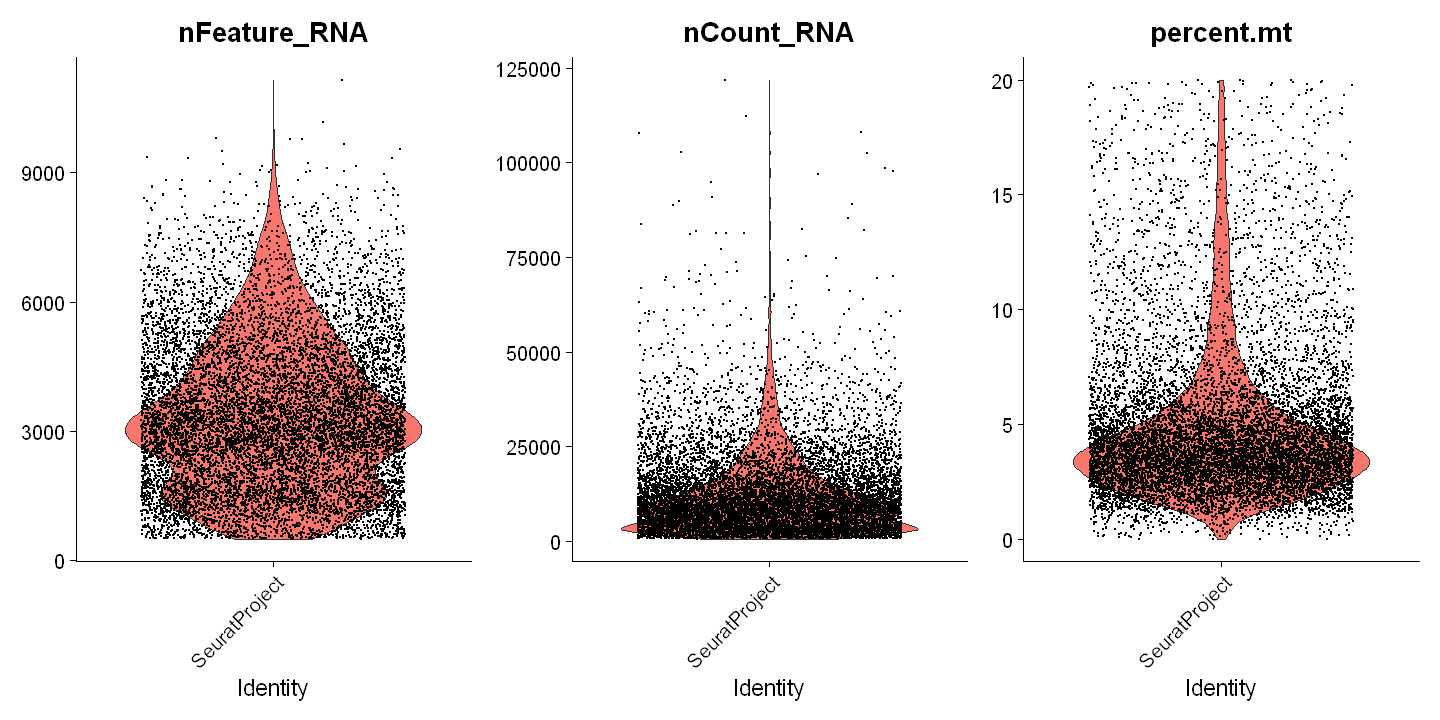

In [45]:
VlnPlot(merged, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), group.by = "orig.ident", ncol = 3)

In [47]:
# to check how well integration went
preintegrated_object <- merged

In [ ]:
preintegrated_object <- NormalizeData(preintegrated_object)
preintegrated_object <- FindVariableFeatures(preintegrated_object, selection.method = "vst", nfeatures = 2000)
preintegrated_object <- ScaleData(preintegrated_object)
preintegrated_object <- RunPCA(preintegrated_object, features = VariableFeatures(object = preintegrated_object))

In [ ]:
preintegrated_object <- FindNeighbors(preintegrated_object, dims =1:13, reduction = "pca")
preintegrated_object <- FindClusters(preintegrated_object, resolution = 2, cluster.name = "unintegrated_clusters")

18:41:51 UMAP embedding parameters a = 0.9922 b = 1.112

18:41:51 Read 12053 rows and found 13 numeric columns

18:41:51 Using Annoy for neighbor search, n_neighbors = 30

18:41:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:41:52 Writing NN index file to temp file C:\Users\48721\AppData\Local\Temp\RtmpsXgZGW\file5fb0615d278

18:41:52 Searching Annoy index using 1 thread, search_k = 3000

18:41:56 Annoy recall = 100%

18:41:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:41:58 Initializing from normalized Laplacian + noise (using RSpectra)

18:41:59 Commencing optimization for 200 epochs, with 485540 positive edges

18:42:09 Optimization finished



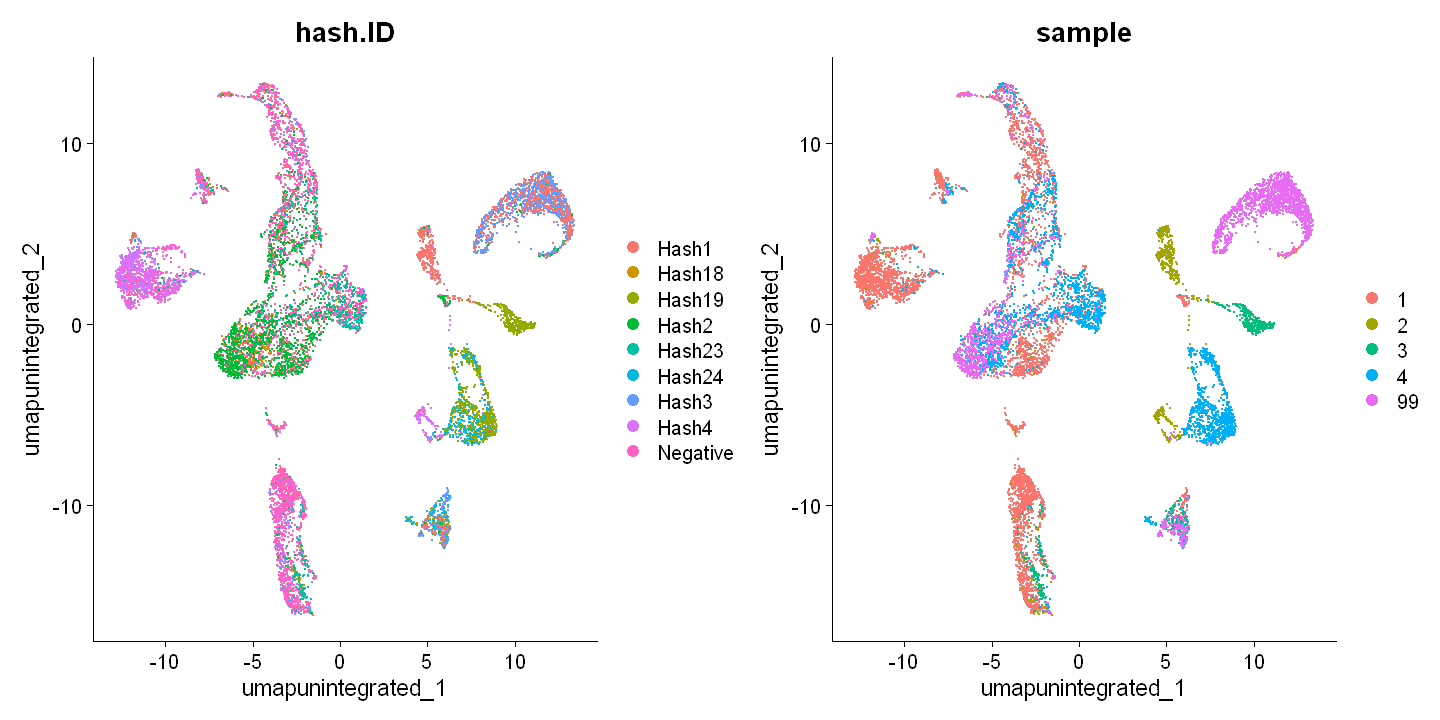

In [50]:
preintegrated_object <- RunUMAP(preintegrated_object, dims =1:13, reduction = "pca", reduction.name = "umap.unintegrated")
DimPlot(preintegrated_object, reduction = "umap.unintegrated", group.by = c("hash.ID", "sample"))

In [51]:
integration <- preintegrated_object

2. Integration:

https://satijalab.org/seurat/articles/seurat5_integration

In [ ]:
harmony_obj <- IntegrateLayers(
  object = integration, method = HarmonyIntegration,
  orig.reduction = "pca", new.reduction = "harmony",
  verbose = FALSE
)

Warning message:
"HarmonyMatrix is deprecated and will be removed in the future from the API in the future"


Computing nearest neighbor graph

Computing SNN

18:47:49 UMAP embedding parameters a = 0.9922 b = 1.112

18:47:49 Read 12053 rows and found 13 numeric columns

18:47:49 Using Annoy for neighbor search, n_neighbors = 30

18:47:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:47:50 Writing NN index file to temp file C:\Users\48721\AppData\Local\Temp\RtmpsXgZGW\file5fb04e1b735f

18:47:50 Searching Annoy index using 1 thread, search_k = 3000

18:47:52 Annoy recall = 100%

18:47:53 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:47:55 Initializing from normalized Laplacian + noise (using RSpectra)

18:47:55 Commencing optimization for 200 epochs, with 492198 positive edges

18:48:05 Optimization finished



[[1]]


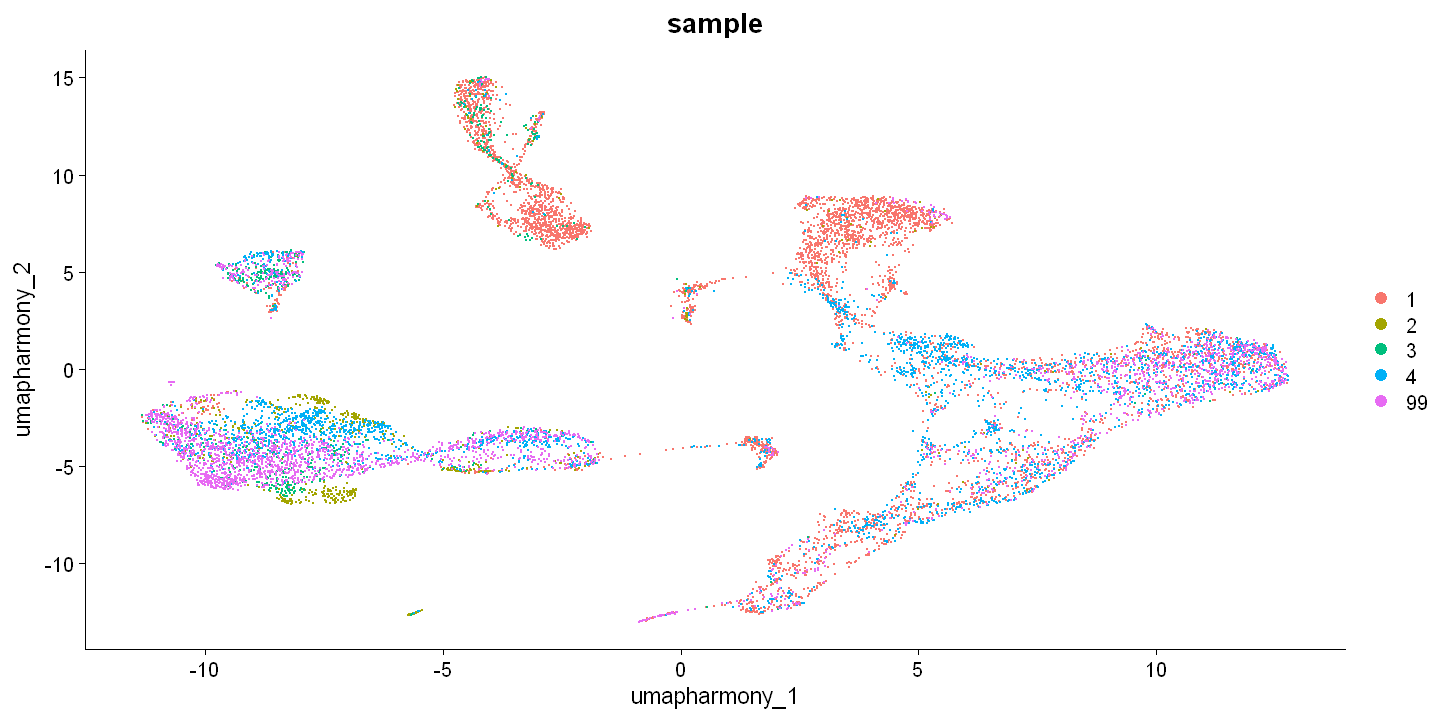

In [ ]:
harmony_obj <- FindNeighbors(harmony_obj, reduction = "harmony", dims =1:13)
harmony_obj <- RunUMAP(harmony_obj, reduction = "harmony", dims =1:13, reduction.name = "umap.harmony")

DimPlot(
  harmony_obj,
  reduction = "umap.harmony",
  group.by = "sample",
  combine = FALSE, label.size = 2
)

In [66]:
harmony_obj <- JoinLayers(harmony_obj)

In [67]:
seurat_integrated <- harmony_obj

In [ ]:
set.seed(123456789)
library(mclust)
# Clustering solutions
nmbDims = 10
startRes=0.1
endRes=3
step=0.1
for(i in seq(startRes,endRes,step)) {
resCluster=i
seurat_integrated <- FindClusters(seurat_integrated, dims.use = 1:nmbDims, force.recalc=TRUE, save.SNN = T, resolution = resCluster)
}


# Adjusted rand index

ARImatrix=matrix(nrow=length(seq(startRes,endRes,step)),ncol=length(seq(startRes,endRes,step)))
for(i in 1:length(seq(startRes,endRes,step))) {
	for(j in 1:length(seq(startRes,endRes,step))) {
		if(i!=j) {
			vecA=seurat_integrated@meta.data[,paste("RNA_snn_res.",seq(startRes,endRes,step)[i],sep="")]
			vecB=seurat_integrated@meta.data[,paste("RNA_snn_res.",seq(startRes,endRes,step)[j],sep="")]
			ARImatrix[i,j]=adjustedRandIndex(vecA,vecB)
		}
	}
}

In [ ]:
library(reshape2)
library(ggplot2)
ARImean=NULL
ARIsd=NULL
ARInmbClusters=NULL
for(i in 1:length(seq(startRes,endRes,step))) {
	ARImean=c(ARImean,mean(ARImatrix[i,-i]))
	ARIsd=c(ARIsd,sd(ARImatrix[i,-i]))
	ARInmbClusters=c(ARInmbClusters,length(unique(seurat_integrated@meta.data[,paste("RNA_snn_res.",seq(startRes,endRes,step)[i],sep="")])))
}
optimalRes=seq(startRes,endRes,step)[which(ARImean==max(ARImean))[1]]
ARIdf=data.frame(resolution=seq(startRes,endRes,step), ARI_mean=ARImean, ARI_sd=ARIsd, number_clusters=ARInmbClusters)
ARIdf=melt(ARIdf,id='resolution')

# Plot ARI values

print(ggplot(ARIdf, aes(x = resolution, y = value, fill = variable)) + geom_line(aes(group=variable,color=variable), size = 1.2) + labs(y=NULL) + labs(x = "resolution") + ggtitle("Adjusted Rand Index") + facet_grid(variable ~ . , scales = "free") + theme_bw() + geom_vline(xintercept=optimalRes,color="orange",linetype="dotted"))

In [73]:
# Zapisanie obiektu Seurat do pliku RDS
saveRDS(seurat_integrated, file = "integrated_object.rds")

In [2]:
seurat_integrated <- readRDS("integrated_object.rds")

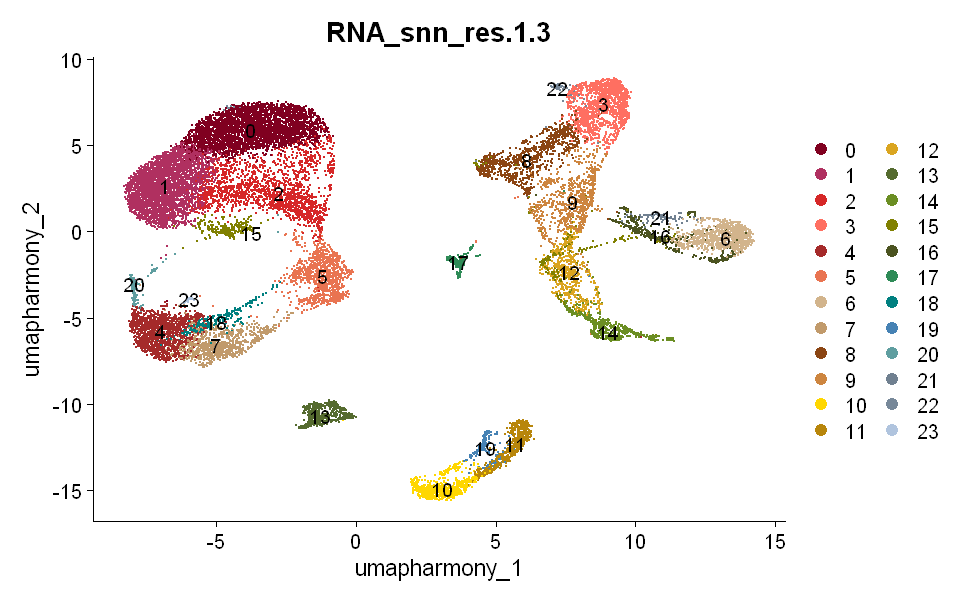

In [18]:
cols_30 <- c(
  "#800020", "#B03060", "#D62728", "#FF6F61", "#A52A2A", "#E97451",
  "#D2B48C", "#C19A6B", "#8B4513", "#CD853F", "#FFD700", "#B8860B",
  "#DAA520", "#556B2F", "#6B8E23", "#808000", "#4B5320", "#2E8B57",
  "#008080", "#4682B4", "#5F9EA0", "#708090", "#778899", "#B0C4DE",
  "#D3D3D3", "#A9A9A9", "#F5F5F5", "#FFF8DC", "#FAEBD7", "#FDF5E6"
)
cols_6 <- c( "#B0C4DE",  "#C19A6B", "#FFD700", "#556B2F","#800020" ,"#B0C4DE", "#808000", "#4B5320", "#2E8B57",
  "#008080", "#4682B4", "#5F9EA0", "#708090", "#778899", "#B0C4DE",
  "#D3D3D3", "#A9A9A9", "#F5F5F5", "#FFF8DC", "#FAEBD7", "#FDF5E6"
)

options(repr.plot.width = 8, repr.plot.height = 5)
DimPlot(seurat_integrated, cols = cols_30,label = TRUE, reduction = "umap.harmony", pt.size = 0.3, raster.dpi = c(1000,1000), group.by = "RNA_snn_res.1.3")


# Gene Annotation 

In [ ]:
library(Seurat)
library(dplyr)

Idents(seurat_integrated) <- "RNA_snn_res.1.3"
all.markers <- FindAllMarkers(
  seurat_integrated,
  only.pos = TRUE,
  min.pct = 0.25,
  logfc.threshold = 0.25
)



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


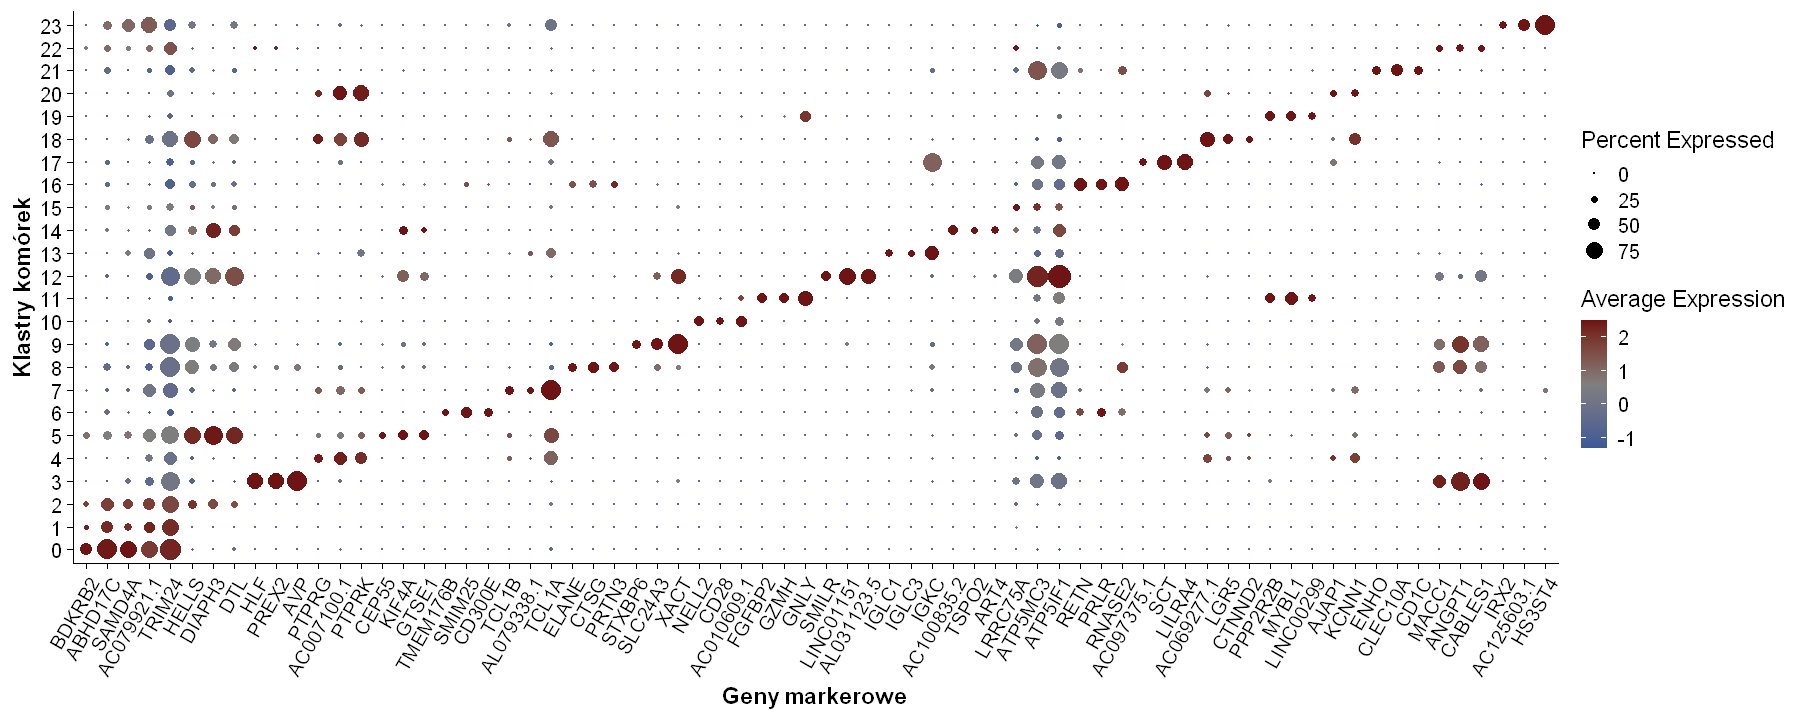

In [59]:
options(repr.plot.width = 15, repr.plot.height = 6)
library(RColorBrewer)
library(viridis)
top_genes <- all.markers %>%
  group_by(cluster) %>%
  slice_max(order_by = avg_log2FC, n = 3) %>%
  pull(gene) 
top_genes <- unique(top_genes)
DotPlot(seurat_integrated, features = top_genes, group.by = "RNA_snn_res.1.3") +
  scale_color_gradientn(colors = c("#3A5998", "#7F7F7F", "#6E1414"))+
   labs(
    x = "Geny markerowe",
    y = "Klastry komórek"
  )+
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(angle = 60, hjust = 1)  
  )


# ADNOTACJA 

In [ ]:
#azimuth analysis
azimuth_analysis <-  RunAzimuth(seurat_integrated, reference = "bonemarrowref")
DimPlot(azimuth_analysis, group.by = "predicted.celltype.l2", label = TRUE)
saveRDS(azimuth_analysis, file = "azimuth_analysis.rds")

p1 <- DimPlot(azimuth_analysis, group.by = "predicted.celltype.l2", reduction = "umap.harmony",label = TRUE)
p2 <- DimPlot(azimuth_analysis, group.by = "RNA_snn_res.1.3", reduction = "umap.harmony",label = TRUE)
combined_plot <- p1 + p2
ggsave("png/umap_combined.png", plot = combined_plot, width = 14, height = 6, dpi = 300)

In [ ]:
p1 <- DimPlot(azimuth_analysis, group.by = "predicted.celltype.l2", reduction = "umap.harmony",label = TRUE)
p2 <- DimPlot(azimuth_analysis, group.by = "RNA_snn_res.1.3", reduction = "umap.harmony",label = TRUE)

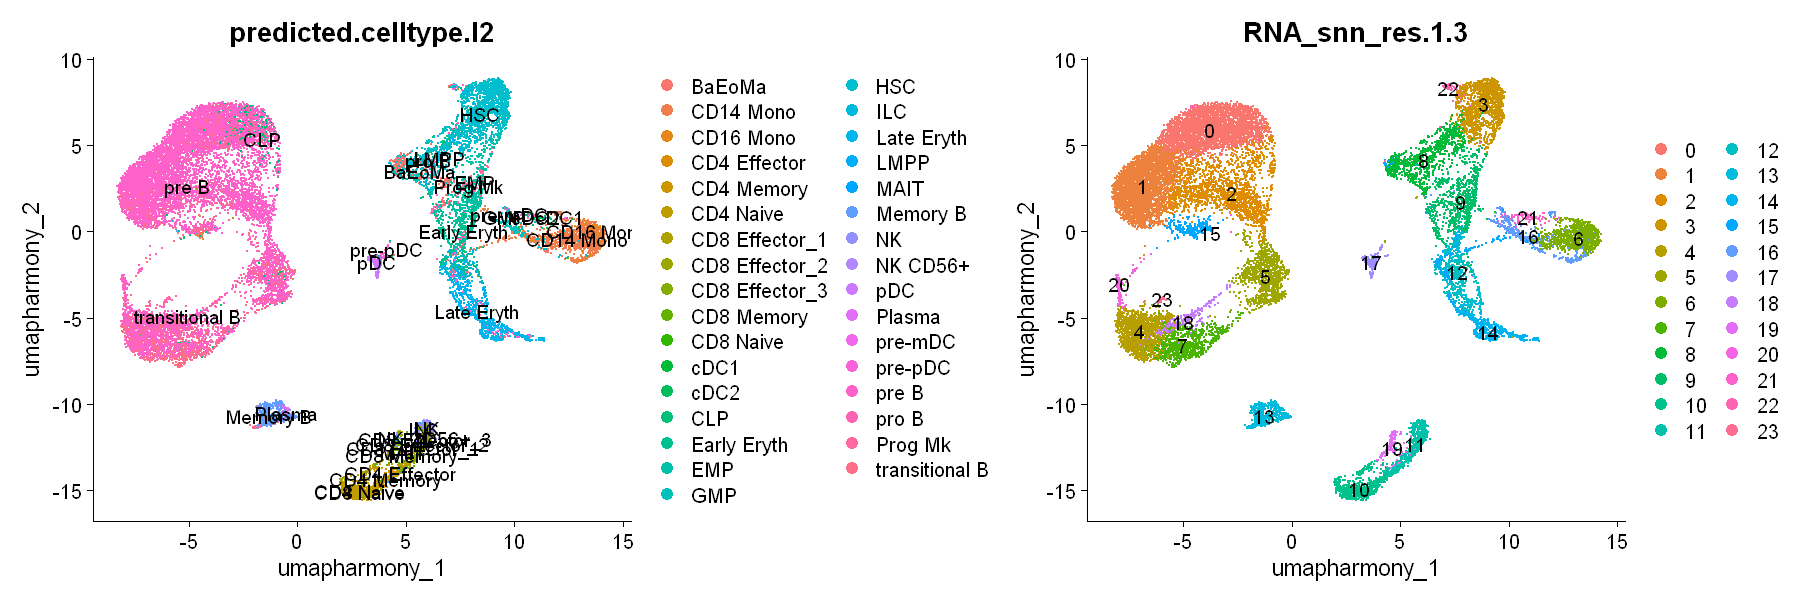

In [5]:
options(repr.plot.width = 15, repr.plot.height = 5)
p1+p2

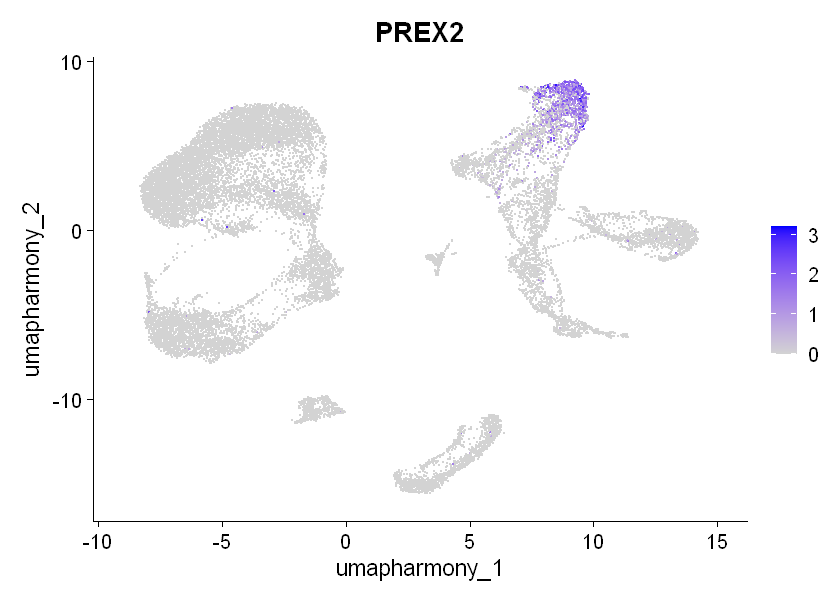

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 5)
FeaturePlot(azimuth_analysis, reduction = "umap.harmony", features = c("PREX2")) 


In [ ]:
grep("CD8", rownames(azimuth_analysis), value = TRUE)

[1] "CD84"     "CD8A"     "CD8B"     "CD8B2"    "CD80"     "CD86"    
 [7] "CD83"     "CD81-AS1" "CD81"     "CD82"

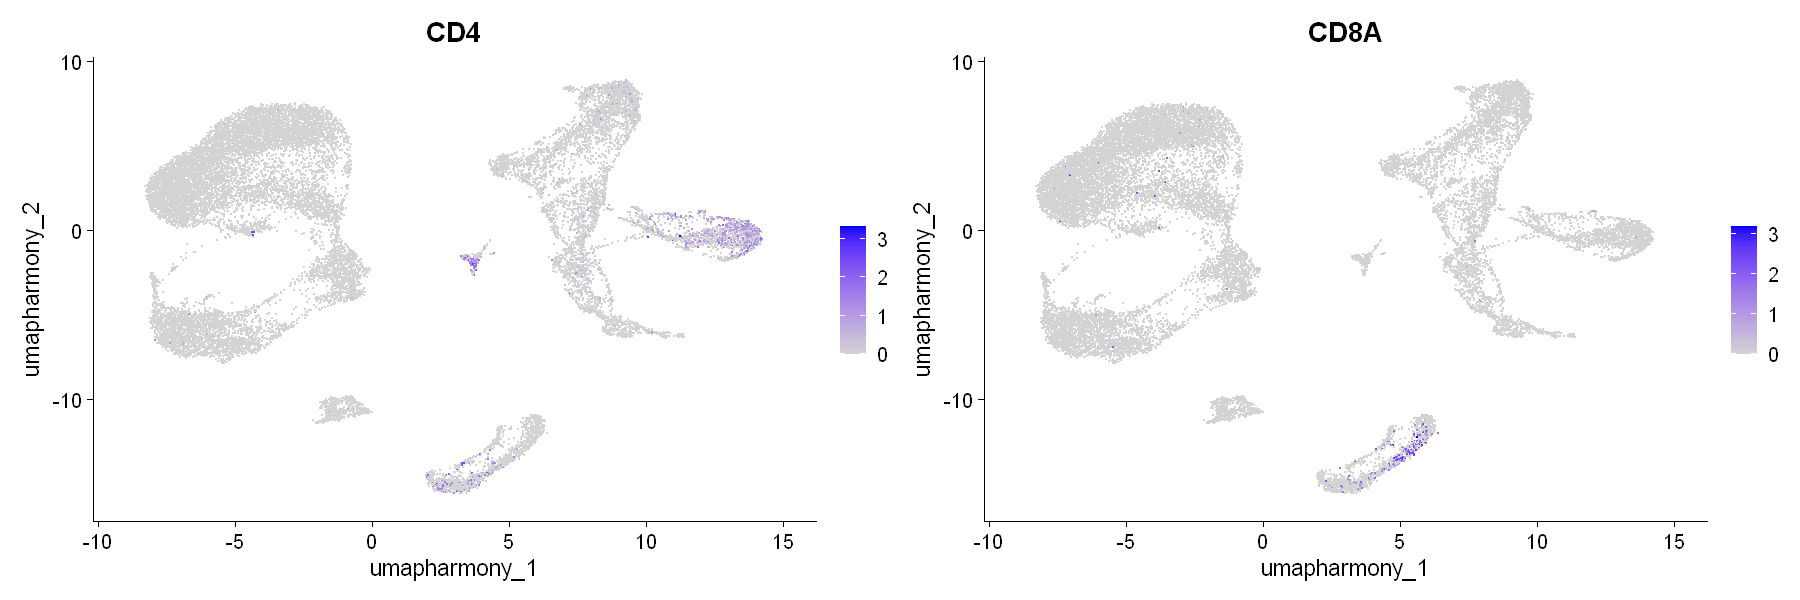

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 5)
FeaturePlot(azimuth_analysis, reduction = "umap.harmony", features = c("CD4", "CD8A")) 

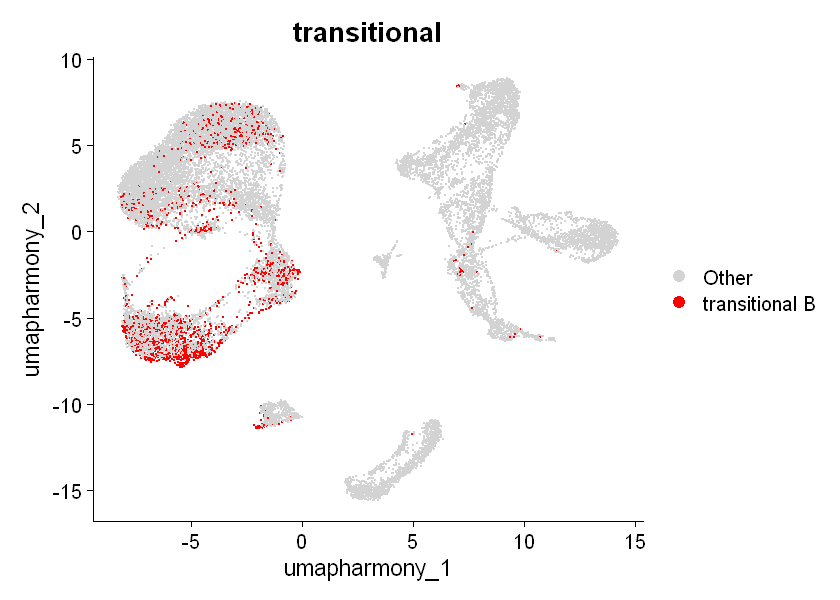

In [ ]:
azimuth_analysis$transitional <- ifelse(azimuth_analysis$predicted.celltype.l2 == "transitional B", "transitional B", "Other")
DimPlot(azimuth_analysis, group.by = "transitional", reduction = "umap.harmony", 
        cols = c("Other" = "lightgrey", "transitional B" = "red"), label = FALSE)

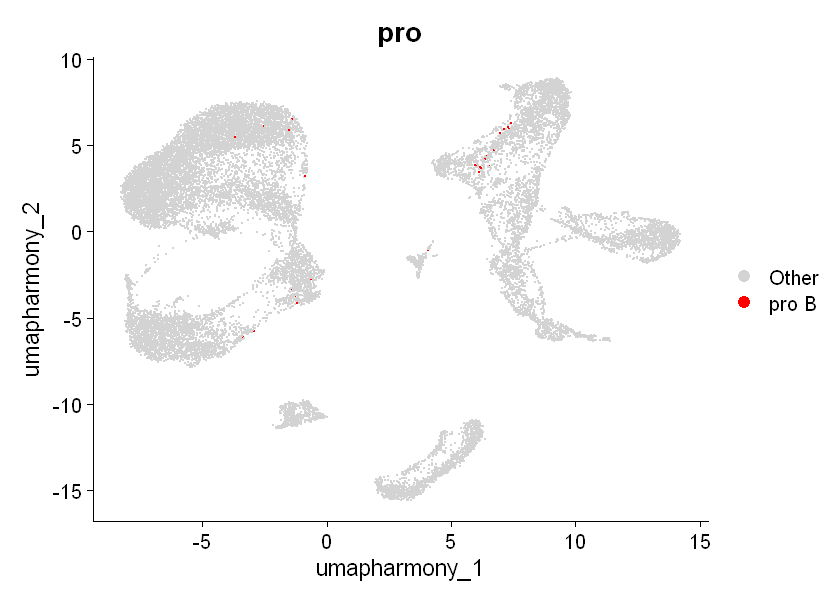

In [ ]:
azimuth_analysis$pro <- ifelse(azimuth_analysis$predicted.celltype.l2 == "pro B", "pro B", "Other")
DimPlot(azimuth_analysis, group.by = "pro", reduction = "umap.harmony", 
        cols = c("Other" = "lightgrey", "pro B" = "red"), label = FALSE)

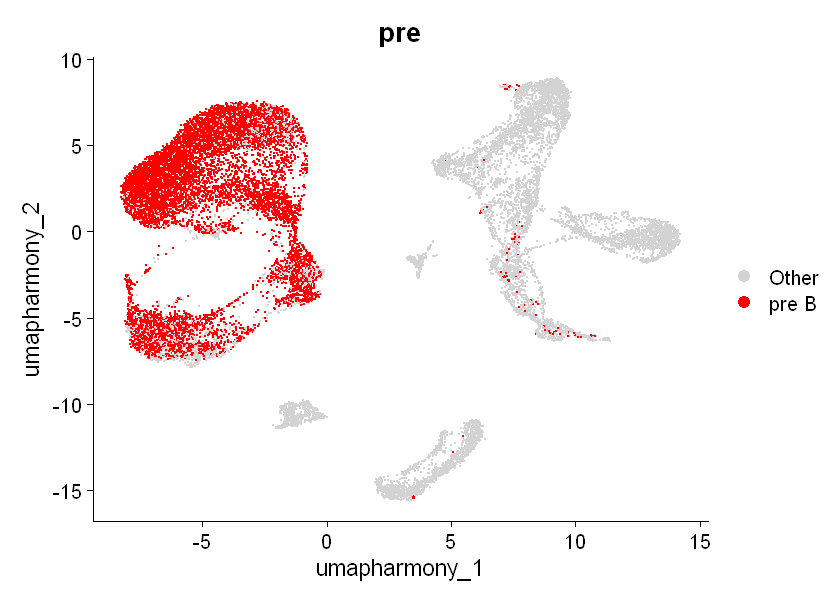

In [ ]:
azimuth_analysis$pre <- ifelse(azimuth_analysis$predicted.celltype.l2 == "pre B", "pre B", "Other")
DimPlot(azimuth_analysis, group.by = "pre", reduction = "umap.harmony", 
        cols = c("Other" = "lightgrey", "pre B" = "red"), label = FALSE)

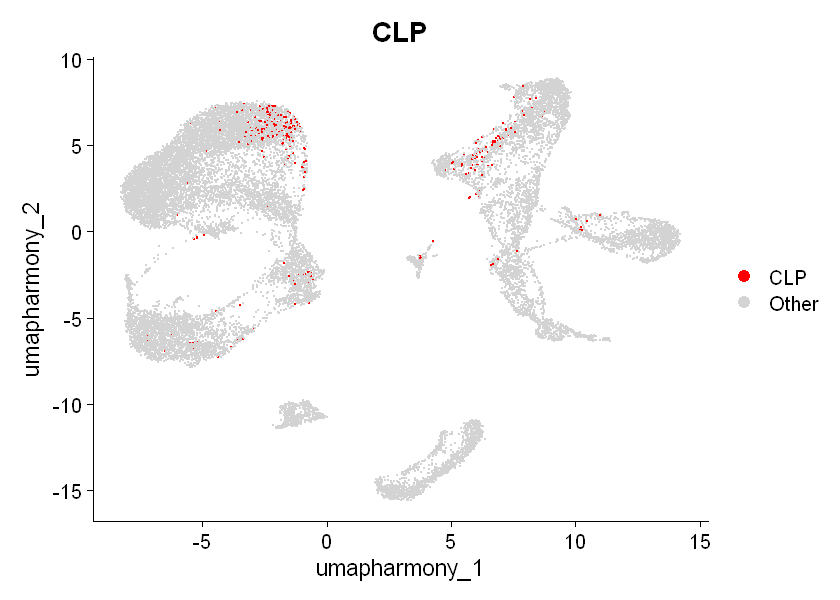

In [ ]:
azimuth_analysis$CLP <- ifelse(azimuth_analysis$predicted.celltype.l2 == "CLP", "CLP", "Other")
DimPlot(azimuth_analysis, group.by = "CLP", reduction = "umap.harmony", 
        cols = c("Other" = "lightgrey", "CLP" = "red"), label = FALSE)

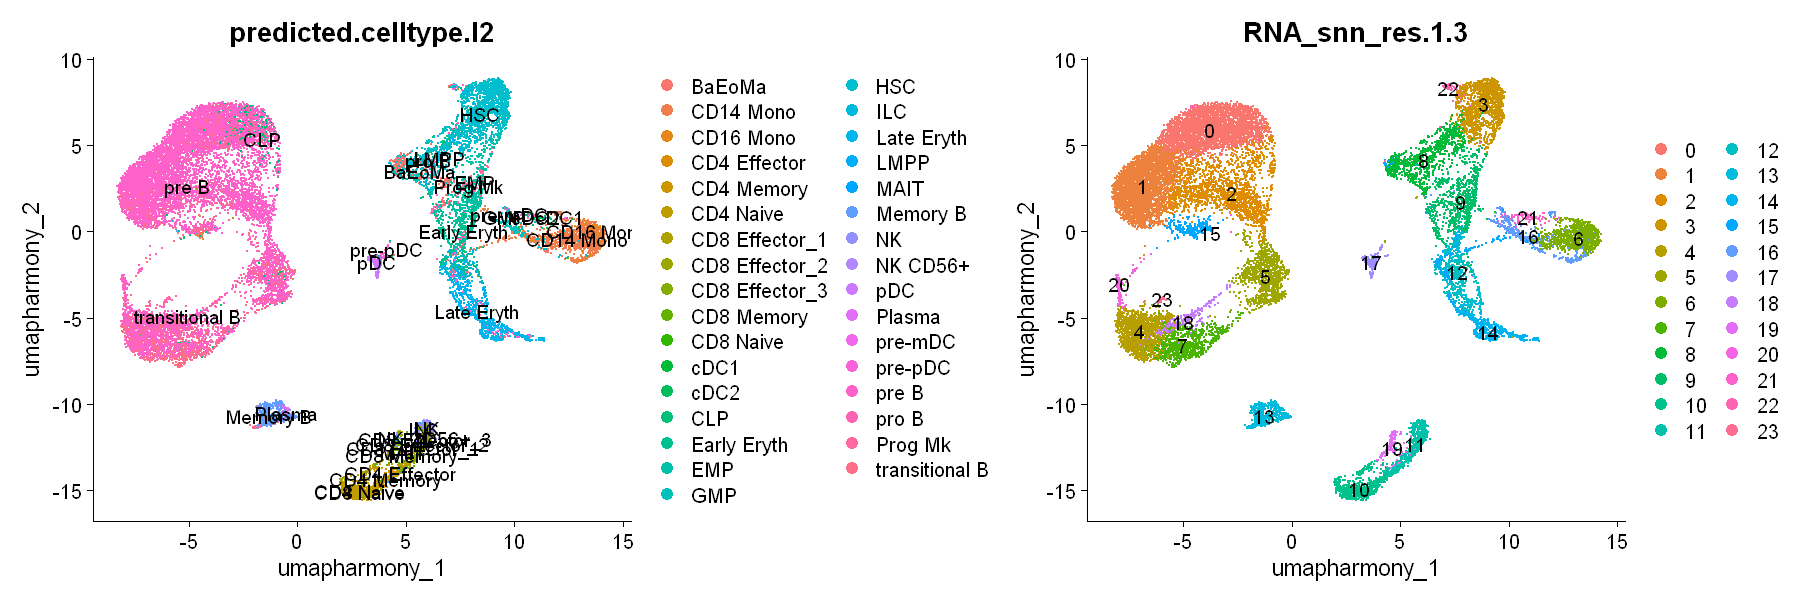

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 5)
p1+p2

In [ ]:
# adnotacja w oparciu o Azimuth, geny markerowe, hash

In [ ]:
Idents(azimuth_analysis) <- azimuth_analysis$RNA_snn_res.1.3

cluster_names_list <- list(
  "Komórki blastyczne (preB/CLP)", 
  "Komórki blastyczne 1 (preB)",
  "Komórki blastyczne 2 (preB)",
  "HSC",
  "Komórki blastyczne 3 (preB)",
  "Komórki blastyczne proliferujące", 
  "monocyty",
  "Komórki blastyczne 4 (preB)",
  "MPP",
  "prekursory erytroidalne i megakariocytarne", 
  "CD4 T-cells",
  "CD8 T-cells",
  "wczesne komórki erytroidalne", 
  "komórki B pamięci",
  "późne komórki erytroidalne",
  "Komórki blastyczne 5 (preB)",
  "GMP",
  "komórki dendrytyczne plazmacytoidalne", 
  "Komórki blastyczne 6 (preB)",
  "komórki NK T",
  "Komórki blastyczne 7 (preB)",
  "komórki dendrytyczne mieloidalne",
  "aktywowane HSC",
  "Komórki blastyczne 8 (preB)"
)
names(cluster_names_list) <- levels(azimuth_analysis)
azimuth_analysis <- RenameIdents(azimuth_analysis, cluster_names_list)

In [4]:
azimuth_analysis$cell_type <- Idents(azimuth_analysis)  


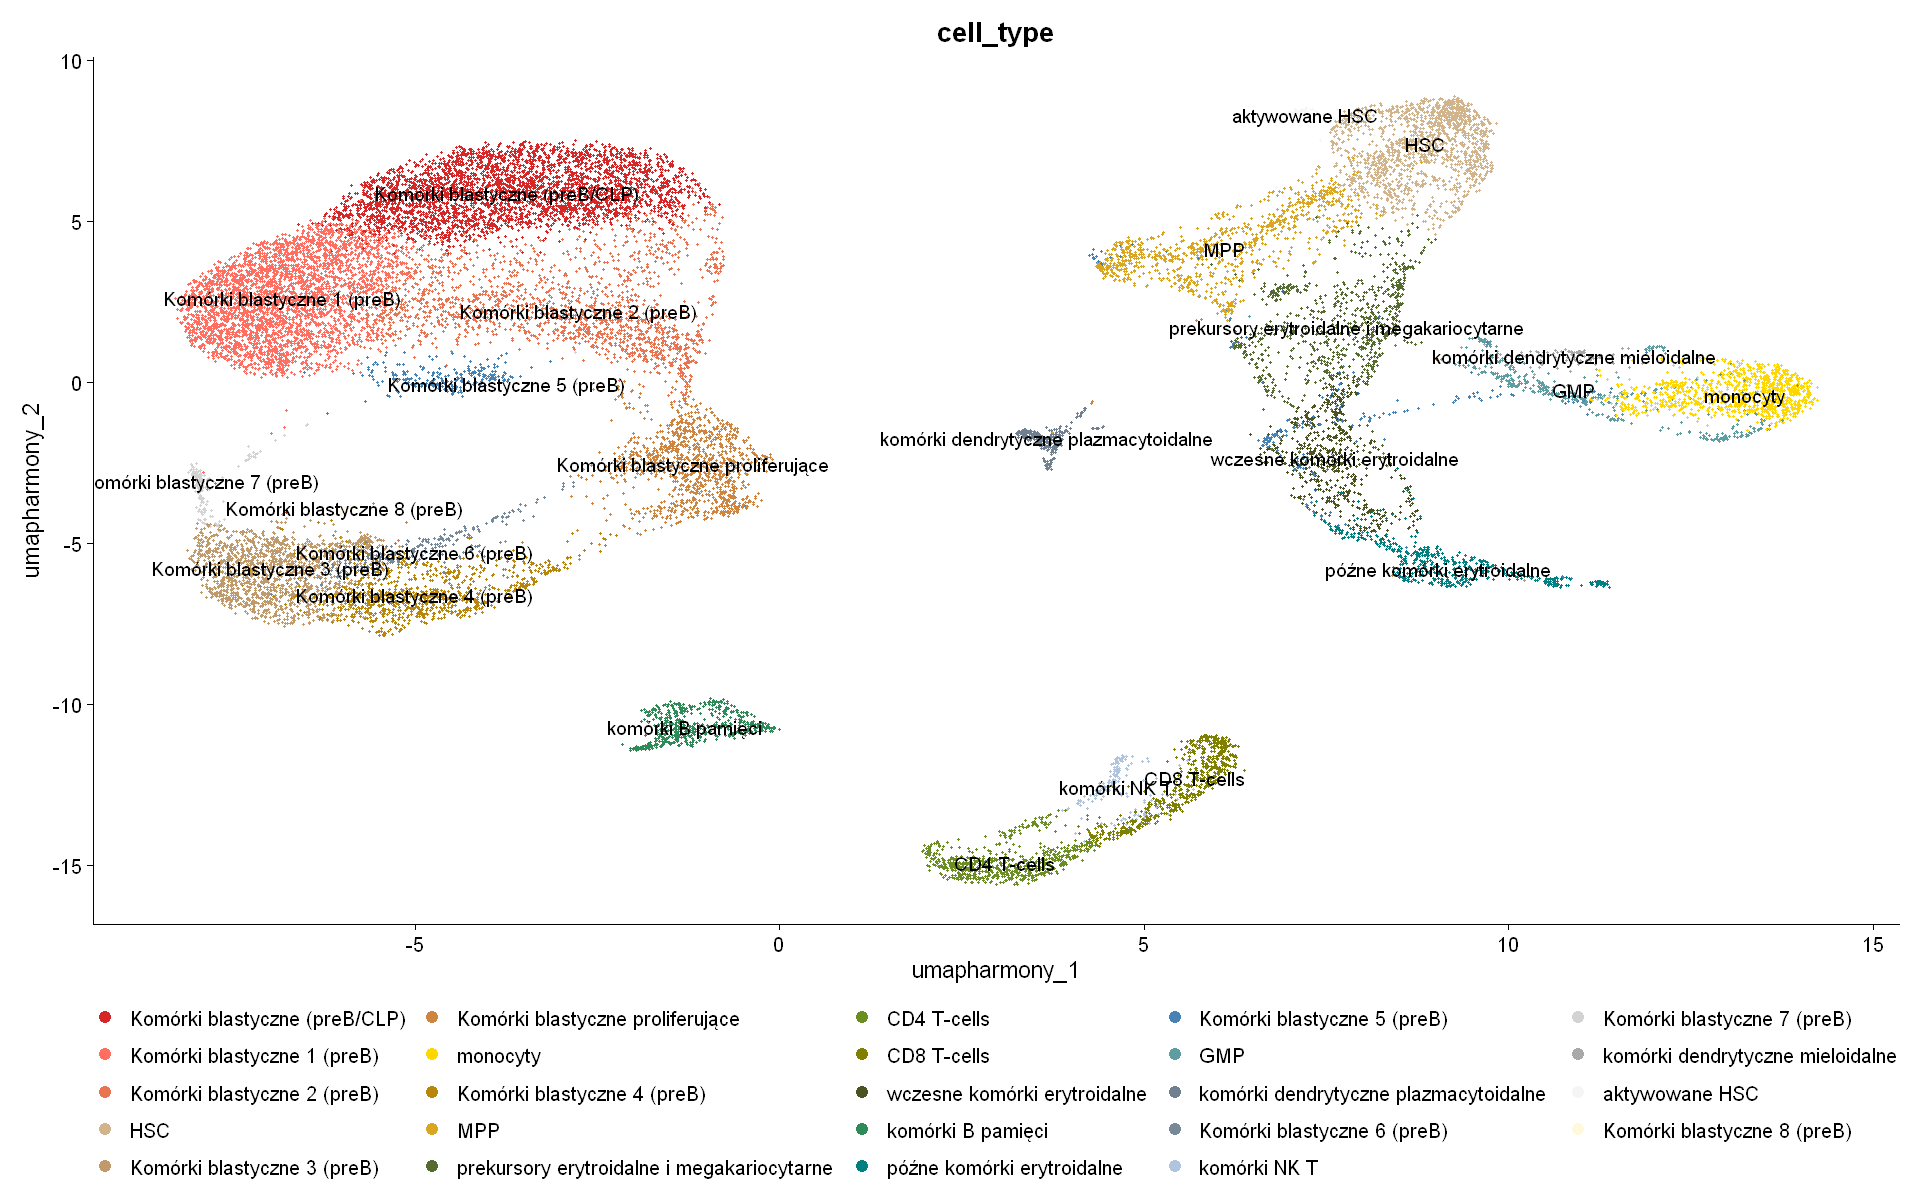

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 10)
library(Seurat)
library(ggplot2)
cols_30 <- c(
    "#D62728", "#FF6F61", "#E97451",
  "#D2B48C", "#C19A6B", "#CD853F", "#FFD700", "#B8860B",
  "#DAA520", "#556B2F", "#6B8E23", "#808000", "#4B5320", "#2E8B57",
  "#008080", "#4682B4", "#5F9EA0", "#708090", "#778899", "#B0C4DE",
  "#D3D3D3", "#A9A9A9", "#F5F5F5", "#FFF8DC", "#FAEBD7", "#FDF5E6"
)
cols_6 <- c( "#B0C4DE",  "#C19A6B", "#FFD700", "#556B2F","#800020" ,"#B0C4DE", "#808000", "#4B5320", "#2E8B57",
  "#008080", "#4682B4", "#5F9EA0", "#708090", "#778899", "#B0C4DE",
  "#D3D3D3", "#A9A9A9", "#F5F5F5", "#FFF8DC", "#FAEBD7", "#FDF5E6"
)


library(ggplot2)
p <- DimPlot(
  azimuth_analysis,
  cols = cols_30,
  group.by = "cell_type",
  reduction = "umap.harmony",
  pt.size = 0.6,
  raster.dpi = c(1000, 1000),
  label = TRUE
) + theme(legend.position = "bottom")

p


In [5]:
seurat_integrated <- azimuth_analysis

In [9]:
saveRDS(seurat_integrated, file = "annotated_object.rds")

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


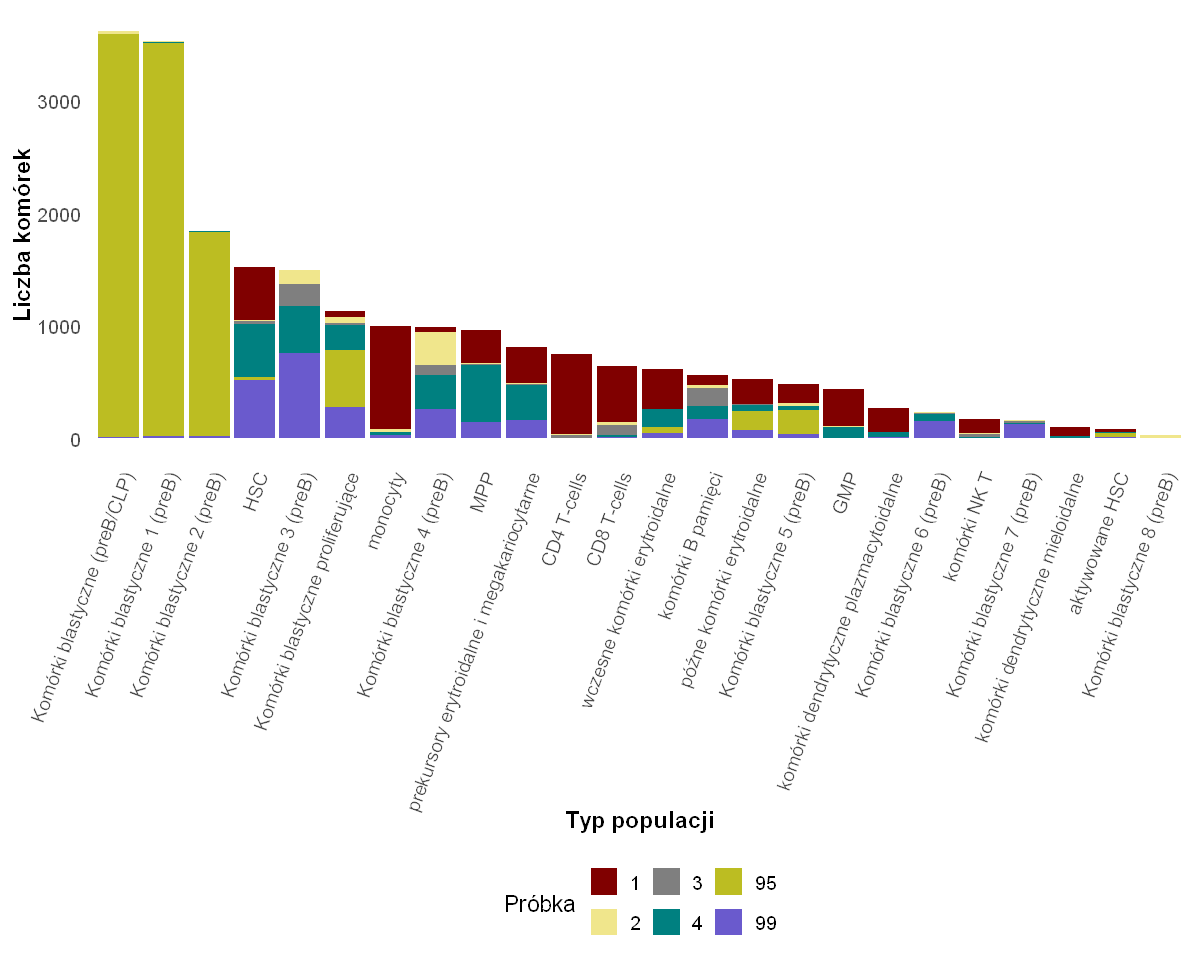

In [34]:
library(Seurat)
library(dplyr)
library(ggplot2)

seurat_integrated$cell_type <- Idents(seurat_integrated)  

df_counts <- seurat_integrated@meta.data %>%
  group_by(cell_type, sample) %>%
  summarise(count = n()) %>%
  ungroup()

my_colors <- c("#800000", "#F0E68C", "#7F7F7F", "#008080", "#BCBD22", "#6A5ACD")

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(df_counts, aes(x = cell_type, y = count, fill = sample)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = my_colors) +
  labs(
    x = "Typ populacji",
    y = "Liczba komórek",
    fill = "Próbka"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    panel.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 70, hjust = 1),
    axis.title = element_text(face = "bold"),
    legend.position = "bottom"
  )


`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


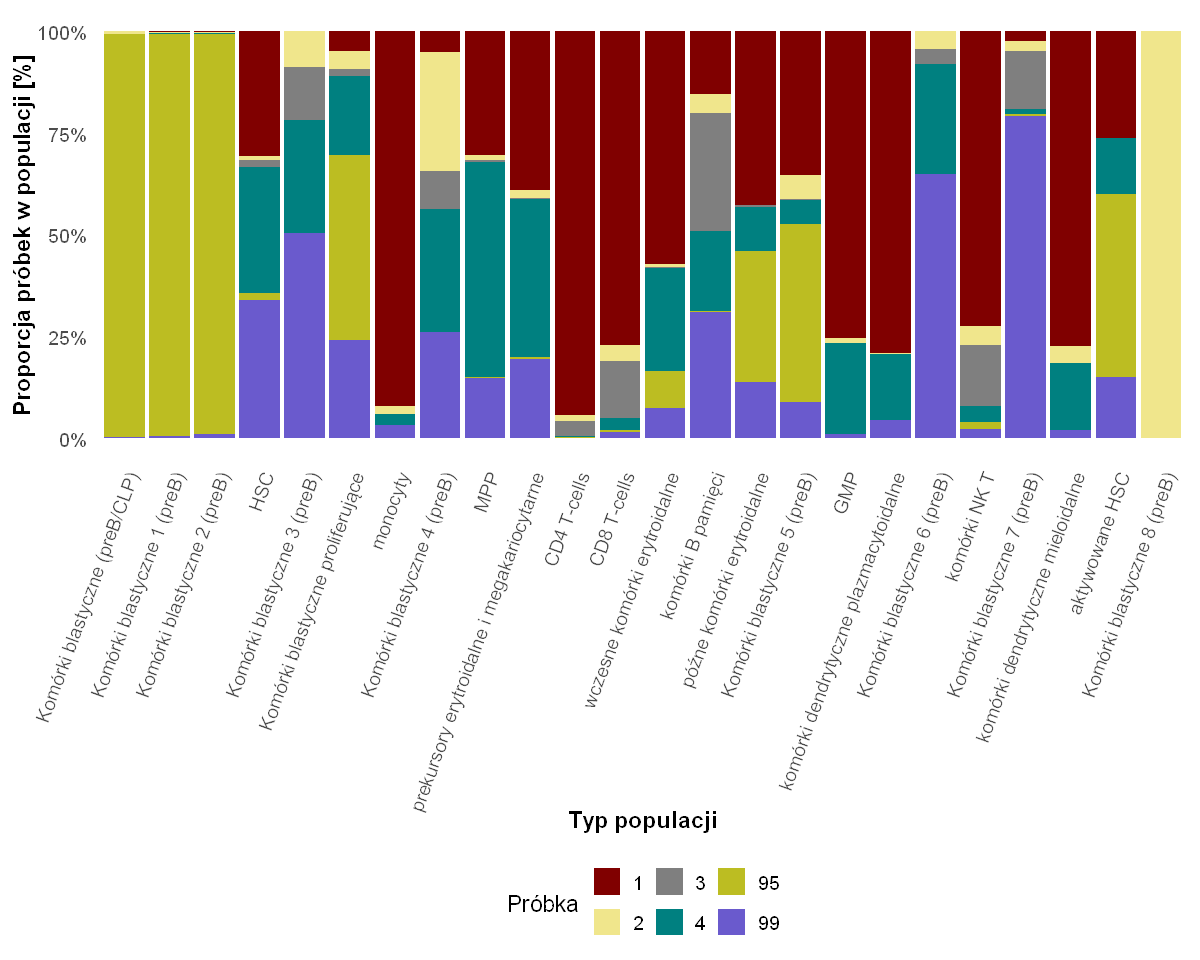

In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)

seurat_integrated$cell_type <- Idents(seurat_integrated)  

df_counts <- seurat_integrated@meta.data %>%
  group_by(cell_type, sample) %>%
  summarise(count = n()) %>%
  ungroup()

total_per_cell_type <- df_counts %>%
  group_by(cell_type) %>%
  summarise(total = sum(count))

df_prop <- df_counts %>%
  left_join(total_per_cell_type, by = "cell_type") %>%
  mutate(proportion = count / total)

my_colors <- c("#800000", "#F0E68C", "#7F7F7F", "#008080", "#BCBD22", "#6A5ACD")

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(df_prop, aes(x = cell_type, y = proportion, fill = sample)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_fill_manual(values = my_colors) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    x = "Typ populacji",
    y = "Proporcja próbek w populacji [%]",
    fill = "Próbka"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    panel.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 70, hjust = 1),
    axis.title = element_text(face = "bold"),
    legend.position = "bottom"
  )


# GSEA

In [1]:
seurat_integrated <- readRDS("integrated_object.rds")

In [ ]:
organism = "org.Hs.eg.db"
# BiocManager::install(organism, character.only = TRUE)
library(organism, character.only = TRUE)

In [5]:
Idents(seurat_integrated) <- "RNA_snn_res.1.3"
hsc_cells <- subset(seurat_integrated, idents = "8")
hsc_cells$condition <- ifelse(hsc_cells$sample == 1, "healthy", "disease")

hsc_healthy <- subset(hsc_cells, subset = condition == "healthy")
hsc_disease <- subset(hsc_cells, subset = condition == "disease")

Idents(hsc_cells) <- "condition"
deg_hsc <- FindMarkers(hsc_cells, ident.1 = "disease", ident.2 = "healthy", group.by = "condition")


Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


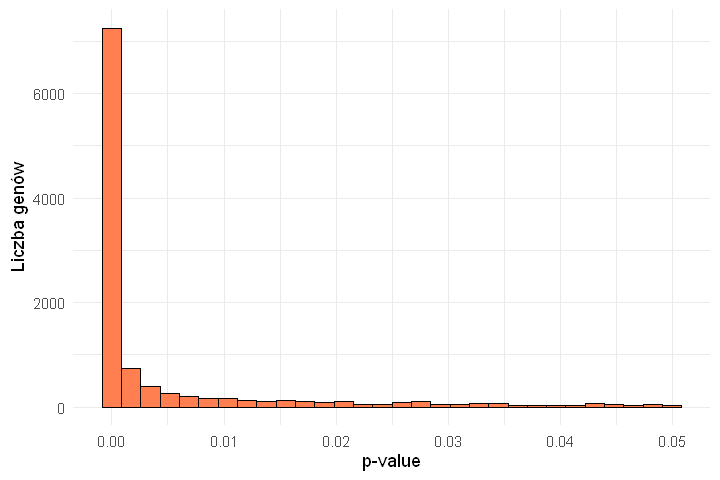

In [74]:
library(ggplot2)

deg_hsc_sub <- deg_hsc %>% filter(p_val < 0.05)
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(deg_hsc_sub, aes(x = p_val)) +
  geom_histogram(bins = 30, fill = "coral", color = "black") +
  theme_minimal() +
  labs( x = "p-value", y = "Liczba genów")


In [7]:
nrow(deg_hsc)
head(deg_hsc)
sum(deg_hsc$p_val < 1e-20)


[1] 16564

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATP8B4,1.588937e-129,4.766474,0.990,0.262,5.815669e-125
AREG,2.364535e-124,-4.530743,0.231,0.935,8.654433e-120
FKBP5,2.423893e-107,-2.667375,0.757,0.976,8.871692e-103
PLCG2,1.394521e-101,-2.075427,0.909,0.990,5.104087e-97
MT-ATP8,8.001462e-101,-1.756311,0.981,0.993,2.928615e-96
RPS29,7.880021e-92,-1.233804,0.978,0.997,2.884166e-87


[1] 182

In [9]:
library(tibble)

In [10]:
sig_genes <- deg_hsc %>%
  filter(p_val_adj < 1e-20) %>%
  rownames_to_column(var = "gene")

gene_entrez <- bitr(sig_genes$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(sig_genes$gene, fromType = "SYMBOL", toType = "ENTREZID", :
"9.82% of input gene IDs are fail to map..."


In [11]:
ego <- enrichGO(gene = gene_entrez$ENTREZID,
                OrgDb = org.Hs.eg.db,
                ont = "BP",      # lub "MF", "CC"
                pAdjustMethod = "BH",
                pvalueCutoff = 0.05,
                readable = TRUE)


In [93]:
ego_MF <- enrichGO(gene = gene_entrez$ENTREZID,
                OrgDb = org.Hs.eg.db,
                ont = "MF",      # lub "MF", "CC"
                pAdjustMethod = "BH",
                pvalueCutoff = 0.05,
                readable = TRUE)


In [77]:
options(repr.plot.width = 20, repr.plot.height = 10)
ego <- pairwise_termsim(ego)


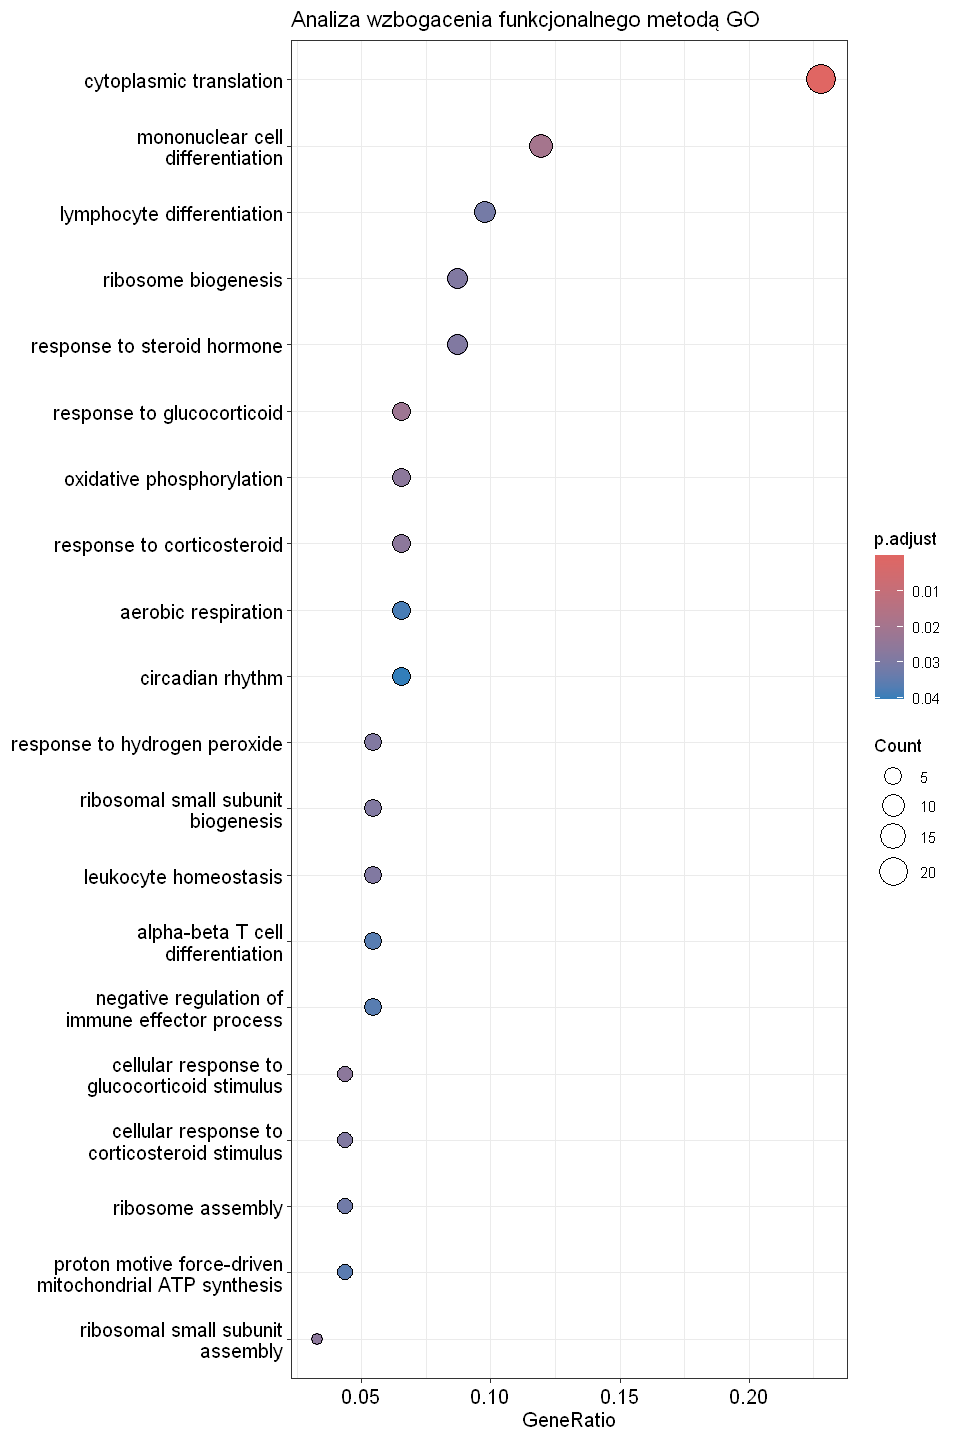

In [12]:
options(repr.plot.width = 8, repr.plot.height = 12)
dotplot(ego, showCategory = 20) + ggtitle("Analiza wzbogacenia funkcjonalnego metodą GO")

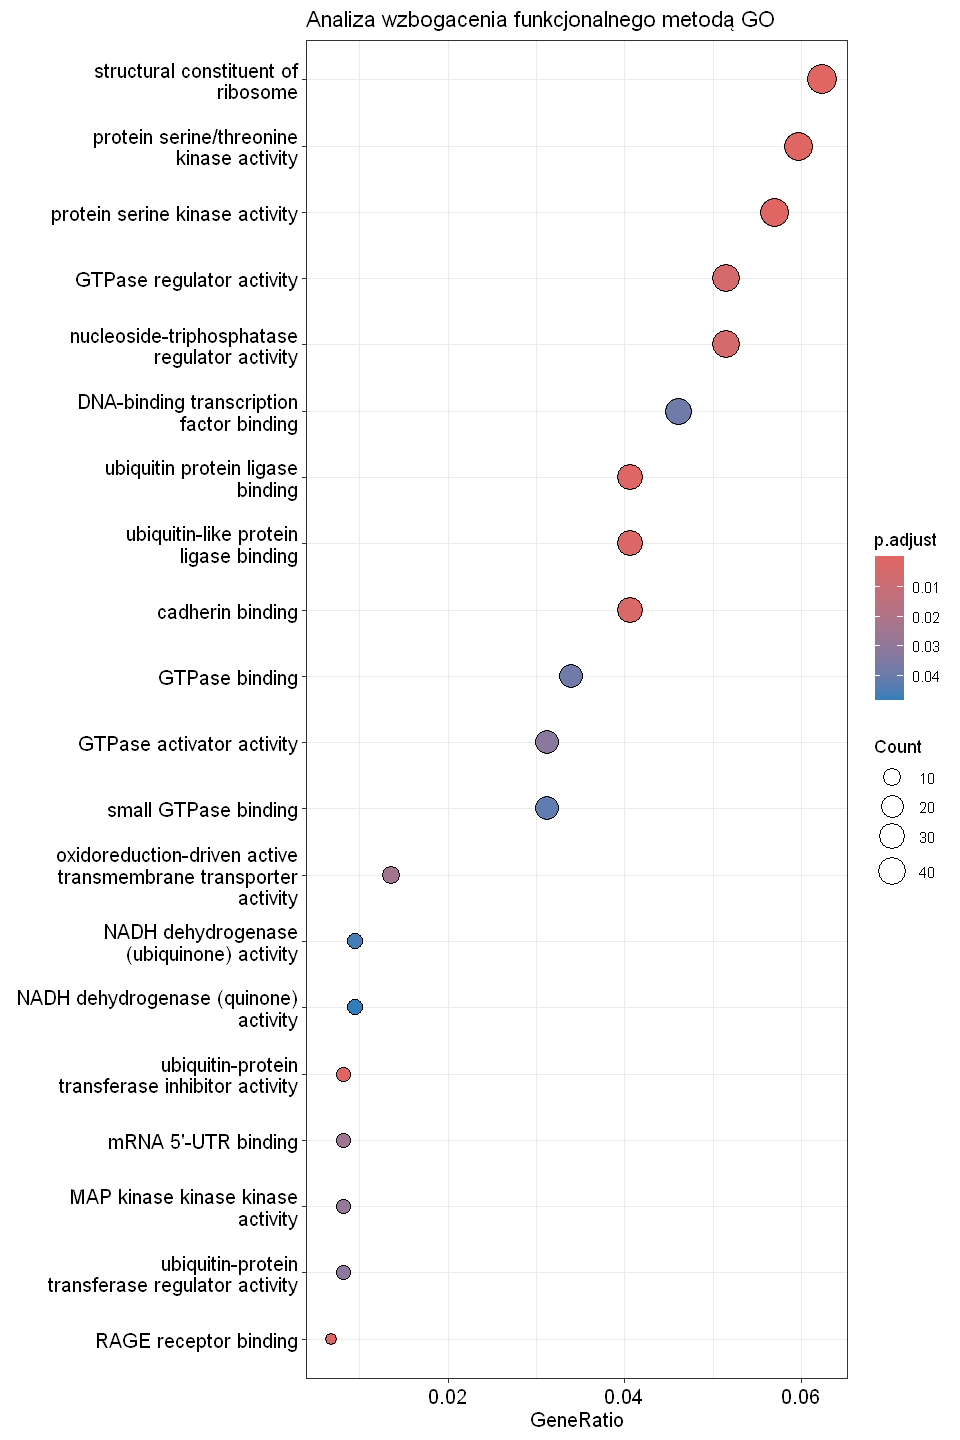

In [94]:
options(repr.plot.width = 8, repr.plot.height = 12)
dotplot(ego_MF, showCategory = 20) + ggtitle("Analiza wzbogacenia funkcjonalnego metodą GO")

## gseGO

In [95]:
gene_list <- deg_hsc %>%
  arrange(desc(avg_log2FC)) %>%  
  pull(avg_log2FC)
names(gene_list) <- rownames(deg_hsc)

gene_list_named <- bitr(names(gene_list),
                        fromType = "SYMBOL",
                        toType = "ENTREZID",
                        OrgDb = org.Hs.eg.db)

gene_list <- gene_list[gene_list_named$SYMBOL]
names(gene_list) <- gene_list_named$ENTREZID
gene_list <- sort(gene_list, decreasing = TRUE)  

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(names(gene_list), fromType = "SYMBOL", toType = "ENTREZID", :
"22.07% of input gene IDs are fail to map..."


In [96]:
gse_go_result <- gseGO(
  geneList = gene_list,
  OrgDb = org.Hs.eg.db,
  keyType = "ENTREZID",
  ont = "ALL",            # lub "MF", "CC"
  minGSSize = 10,
  maxGSSize = 500,
  pvalueCutoff = 0.0005,
  verbose = TRUE
)


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



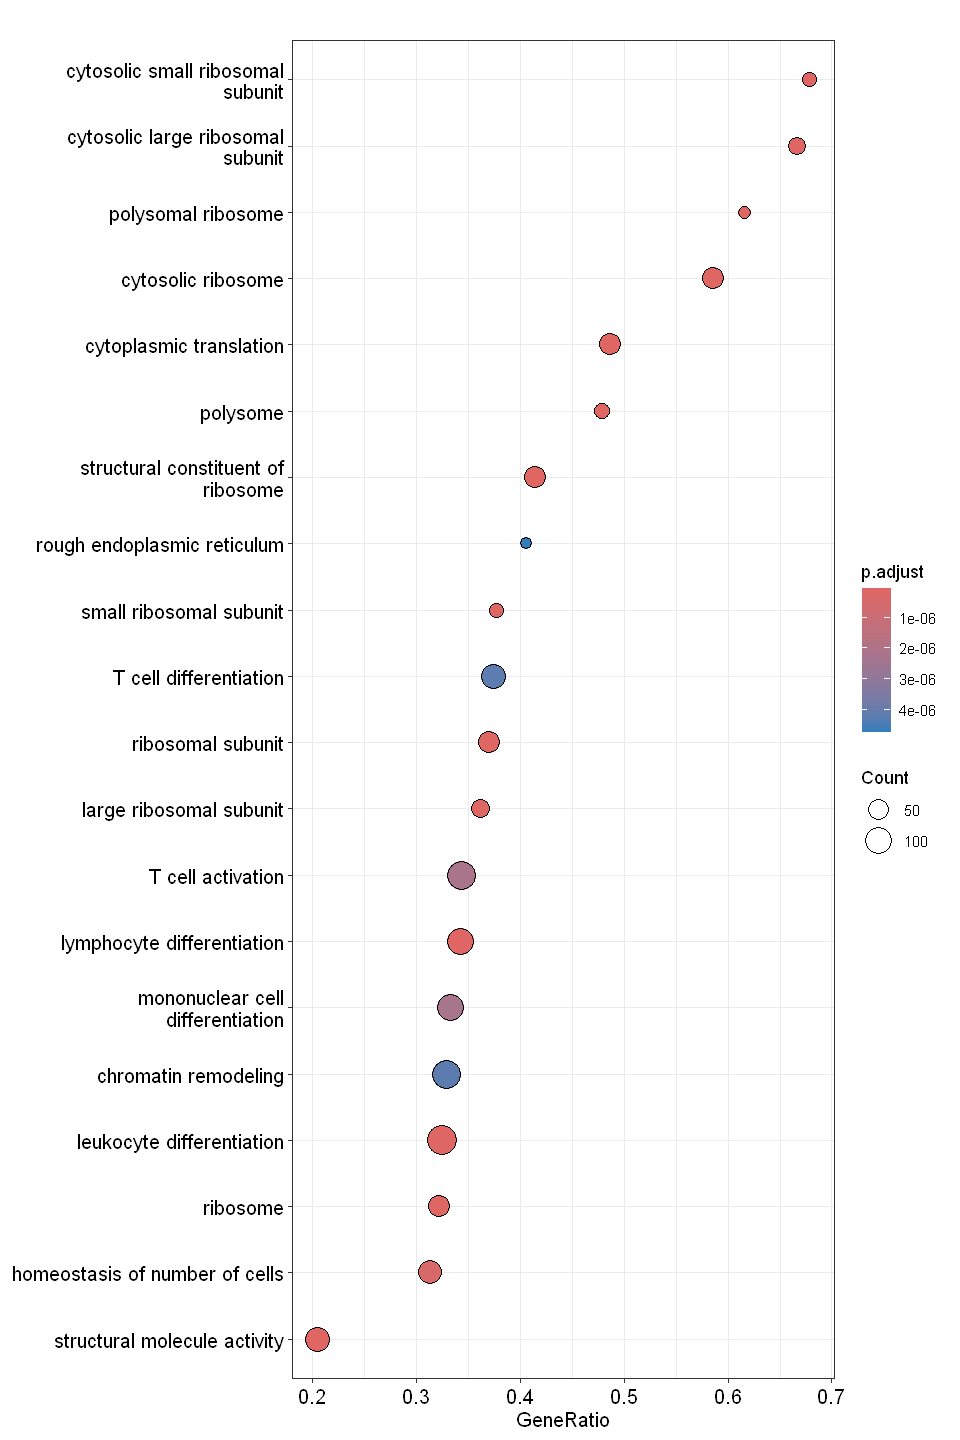

In [97]:
dotplot(gse_go_result, showCategory = 20)